In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import seaborn as sns
from decimal import Decimal
plt.style.use('science')
plt.rcParams['figure.figsize'] = (6, 7)
plt.rcParams['font.size'] = 14
from neutrons.process.data_processor import TotalProcessor, AbsorptionProcessor
from scipy.integrate import  cumulative_trapezoid
from neutrons.process import angular_processor

H_data_a = pd.read_csv('../data/h_cross_a.txt',sep=r'\s+')
H_data_t = pd.read_csv('../data/h_cross_t.txt',sep=r'\s+')
H_data_s = pd.read_csv('../data/h_cross_s.txt',sep=r'\s+')

O_data_a = pd.read_csv('../data/o_cross_a.txt',sep=r'\s+')
O_data_t = pd.read_csv('../data/o_cross_t.txt',sep=r'\s+')
O_data_s = pd.read_csv('../data/o_cross_s.txt',sep=r'\s+')
processor = TotalProcessor([H_data_t, O_data_t])

H_data_angular = pd.read_csv('../data/H_angular.txt',sep=r'\s+')
O_data_angular = pd.read_csv('../data/O_angular.txt',sep=r',')


def convert_number(s):
    print(s)
    if '-' in s:
        index = s.rfind('-')
        s = s[:index] + 'e-' + s[index+1:]
    elif '+' in s:
        index = s.rfind('+')
        s = s[:index] + 'e' + s[index+1:]
    return float(s)


/tmp/ipykernel_5265/890576839.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


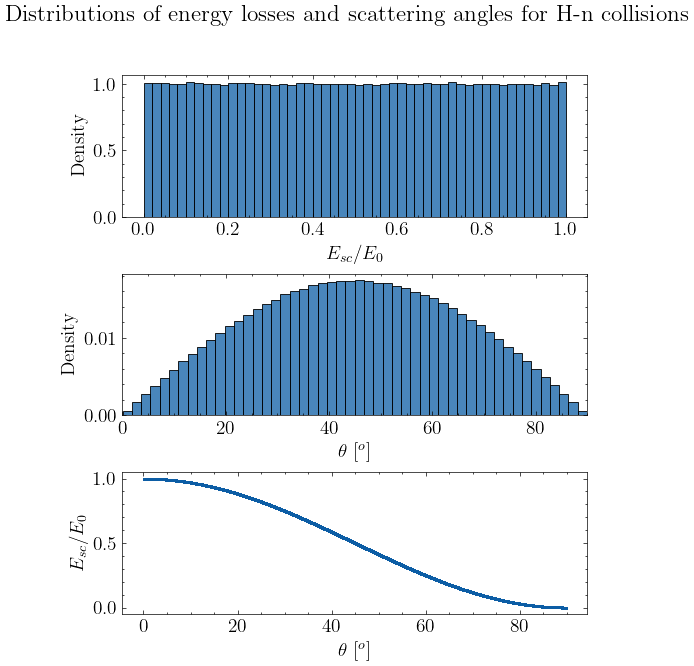

In [2]:
E0 = 1
energies_H = E0 * np.random.random(1000000)
thetas = np.degrees(np.arccos(np.sqrt(energies_H / E0)))

fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.4)

fig.suptitle("Distributions of energy losses and scattering angles for H-n collisions")
sns.histplot(energies_H, bins=50,stat='density', color='C0', ax=axs[0])
axs[0].set_xlabel(r'$E_{sc} / E_0 $')
axs[0].set_ylabel("Density")

sns.histplot(thetas, bins=50,stat='density', color='C0', ax=axs[1])
axs[1].set_xlabel(r'$\theta \ [^o]$')
axs[1].set_ylabel("Density")
axs[1].set_xlim(0, 90)

axs[2].plot(thetas, energies_H, 'o', markersize=1, color='C0')
axs[2].set_ylabel(r'$E_{sc} / E_0 $')
axs[2].set_xlabel(r'$\theta \ [^o]$')

plt.show()

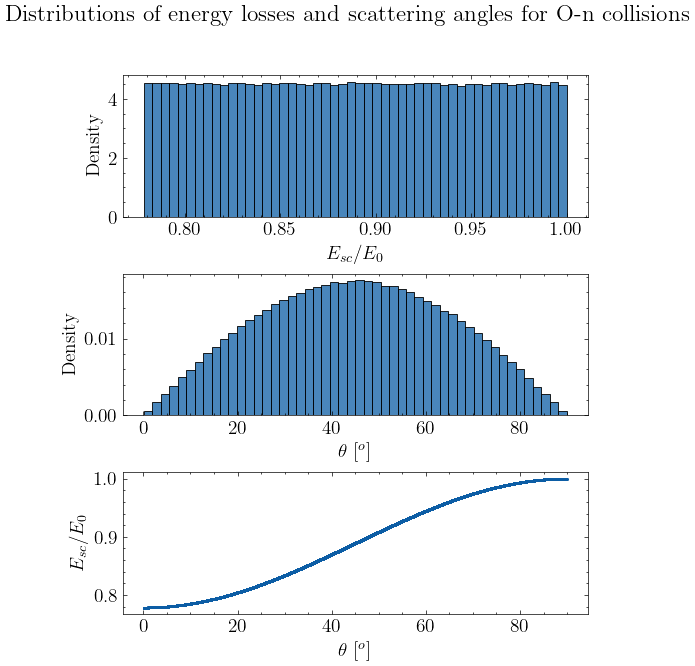

In [4]:
E0 = 1
A = 16
E_min = ((A-1)/(A+1))**2*E0

energies_O = np.random.uniform(E_min, E0, 1000000)

thetas = np.degrees(np.arccos(np.sqrt( ((1+A)**2 / (4*A) )* (E0 - energies_O) / (E0))))

fig, axs = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.4)

fig.suptitle("Distributions of energy losses and scattering angles for O-n collisions")
sns.histplot(energies_O, bins=50,stat='density', color='C0', ax=axs[0])
axs[0].set_xlabel(r'$E_{sc} / E_0 $')
axs[0].set_ylabel("Density")

sns.histplot(thetas, bins=50,stat='density', color='C0', ax=axs[1])
axs[1].set_xlabel(r'$\theta \ [^o]$')
axs[1].set_ylabel("Density")
#axs[1].set_xlim(0, 90)

axs[2].plot(thetas, energies_O, 'o', markersize=1, color='C0')
axs[2].set_ylabel(r'$E_{sc} / E_0 $')
axs[2].set_xlabel(r'$\theta \ [^o]$')

plt.show()

In [202]:
nCollisions = []
for _ in range(100):
    E = 2*10**6
    thetas = []

    n = 0
    while E > 2:
        if np.random.random() < processor.get_ratio(E):
            # H collision
            E_new =E* energies_H[np.random.randint(0, len(energies_H))]
            thetas.append(np.arccos(np.sqrt(E_new / E)))

        else:
            # O collision
            E_new = E* energies_O[np.random.randint(0, len(energies_O))]
            thetas.append(np.arccos(np.sqrt( ((1+A)**2 / (4*A) )* (E - E_new) / (E))))
        n += 1
    
        E = E_new
    
    nCollisions.append(n)

print(f" <no. collisions> = {np.mean(nCollisions)}")
xi = np.log(E0)/np.mean(nCollisions)
print(f"xi = {xi}")
print(f"<Esc / E0> = {1/np.exp(xi)}")


 <no. collisions> = 16.17
xi = 0.8972577451159071
<Esc / E0> = 0.40768610746822675


In [3]:
def legendre_series(coeffs):
    coeffs = [coef * (2*(i+1)+1)/2 for i, coef in enumerate(coeffs)]
    coeffs.insert(0, 0.5)
    return coeffs

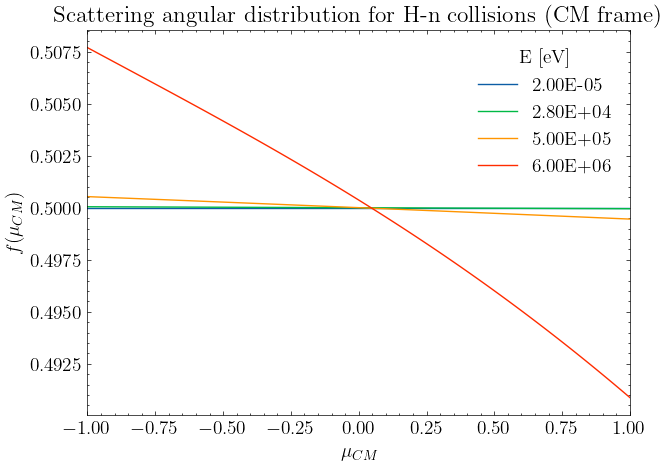

In [4]:
plt.figure(figsize=(7, 5))
x =np.linspace(-1, 1, 100)
for i in range(1, H_data_angular.shape[0], 40):
    coeffs = legendre_series(list(H_data_angular.iloc[i, 1:]))
    plt.plot(x, np.polynomial.legendre.legval(x, coeffs), label= f"{'%.2E' % Decimal(H_data_angular.iloc[i, 0])}")

plt.xlim(-1, 1)    
plt.legend(title='E [eV]')
plt.xlabel(r'$\mu_{CM} $')
plt.ylabel(r'$f(\mu_{CM})$')
plt.title("Scattering angular distribution for H-n collisions (CM frame)")
plt.show()

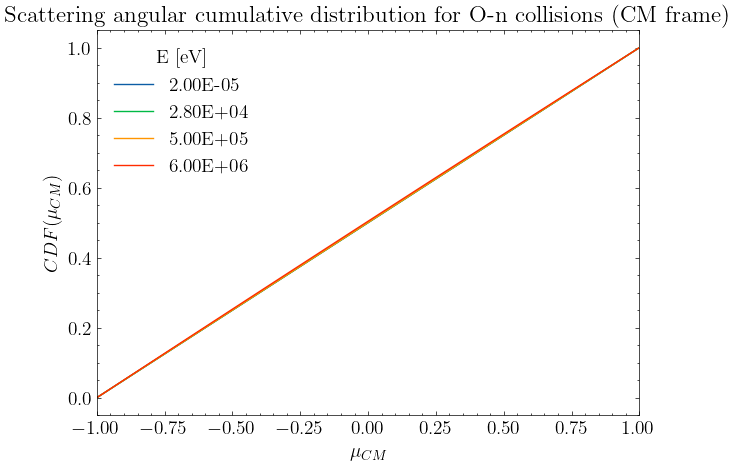

In [5]:
plt.figure(figsize=(7, 5))
x = np.linspace(-1, 1, 100)
for i in range(1, H_data_angular.shape[0], 40):
    coeffs = legendre_series(list(H_data_angular.iloc[i, 1:]))
    pdf = np.polynomial.legendre.legval(x, coeffs)
    cdf = cumulative_trapezoid(pdf, x, initial=0)
    plt.plot(x, cdf, label= f"{'%.2E' % Decimal(H_data_angular.iloc[i, 0])}")

plt.xlim(-1, 1)    
plt.legend(title='E [eV]')
plt.xlabel(r'$\mu_{CM} $')
plt.ylabel(r'$CDF(\mu_{CM})$')
plt.title("Scattering angular cumulative distribution for O-n collisions (CM frame)")
plt.show()

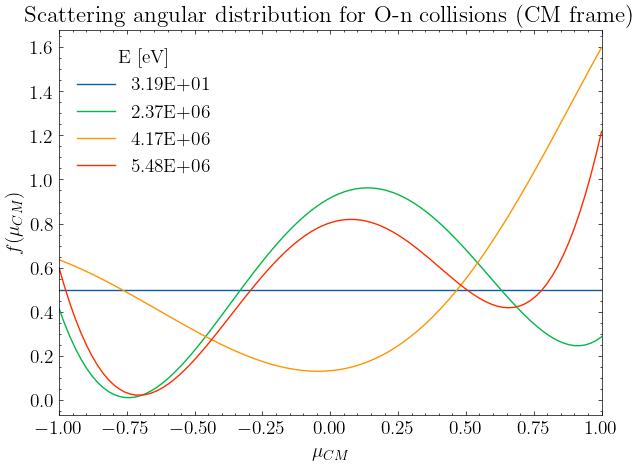

In [16]:
plt.figure(figsize=(7, 5))
x =np.linspace(-1, 1, 100)
for i in range(1, O_data_angular.shape[0], 300):
    coeffs = legendre_series(list(O_data_angular.iloc[i, 1:]))
    plt.plot(x, np.polynomial.legendre.legval(x, coeffs), label= f"{'%.2E' % Decimal(O_data_angular.iloc[i, 0])}")

plt.xlim(-1, 1)    
plt.legend(title='E [eV]')
plt.xlabel(r'$\mu_{CM} $')
plt.ylabel(r'$f(\mu_{CM})$')
plt.title("Scattering angular distribution for O-n collisions (CM frame)")
plt.show()

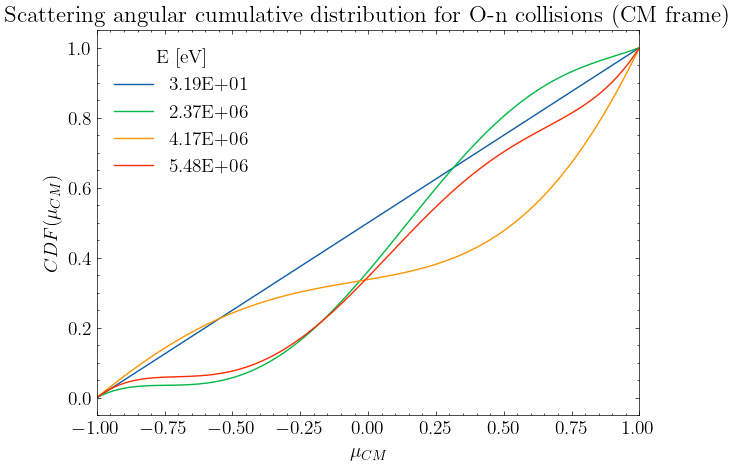

In [7]:
plt.figure(figsize=(7, 5))
x = np.linspace(-1, 1, 100)
for i in range(1, O_data_angular.shape[0], 300):
    coeffs = legendre_series(list(O_data_angular.iloc[i, 1:]))
    pdf = np.polynomial.legendre.legval(x, coeffs)
    cdf = cumulative_trapezoid(pdf, x, initial=0)
    plt.plot(x, cdf, label= f"{'%.2E' % Decimal(O_data_angular.iloc[i, 0])}")

plt.xlim(-1, 1)    
plt.legend(title='E [eV]')
plt.xlabel(r'$\mu_{CM} $')
plt.ylabel(r'$CDF(\mu_{CM})$')
plt.title("Scattering angular cumulative distribution for O-n collisions (CM frame)")
plt.show()

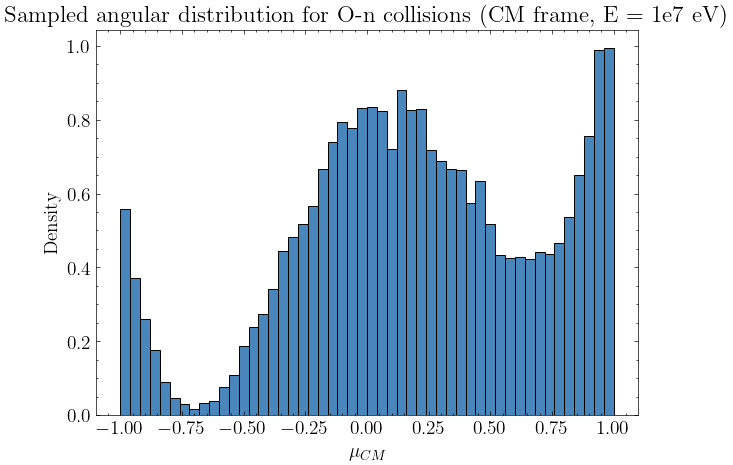

In [13]:
proc = angular_processor.AngularProcessor([H_data_angular, O_data_angular])
angles = proc.get_CM_cosines(16, E=5.48e6, num_samples=10000)

plt.figure(figsize=(7, 5))
sns.histplot(angles, bins=50, stat="density")
plt.xlabel(r"$\mu_{CM}$")
plt.title("Sampled angular distribution for O-n collisions (CM frame, E = 5.48e6 eV)")
plt.show()

In [399]:
def fix_dataset(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    fixed_lines = []
    for i in range(0, len(lines), 2):
        even_row = lines[i]
        odd_row = lines[i+1]

        fixed_line = ''.join(even_row[:-1]) + odd_row[12:] + '\n'
        fixed_lines.append(fixed_line)

    print(fixed_lines)
    with open(filename, 'w') as file:
        file.writelines(fixed_lines)


def remove_blank_rows(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    non_blank_lines = [line for line in lines if line.strip()]

    with open(filename, 'w') as file:
        file.writelines(non_blank_lines)


remove_blank_rows('../data/O_angular.txt')

In [445]:
# Define the width of each column
col_widths = [11] * 11

# Read the fixed-width file
df = pd.read_fwf('../data/O_angular.txt', widths=col_widths, header=None)

df.fillna("0.000000+0", inplace=True)
df = df.map(convert_number)
df.to_csv('../data/O_angular.txt', index=False)

0,coeff1,co


/tmp/ipykernel_22094/91736181.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.000000+0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("0.000000+0", inplace=True)


ValueError: could not convert string to float: '0,coeff1,co'